In [1]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod

from profilehooks import profile
import datetime as dt

import autograd.numpy as np
import autograd.numpy.random as npr

from autograd import grad
from autograd.misc.optimizers import adam
from autograd.core import getval

In [3]:
class BaseBBVIModel(metaclass=ABCMeta):
	"""
	An abstract base class providing the structure for a general Bayesian
	inference problem to be solved using black box variational inference. 
	We provide a number of ELBO graient approximations, with ease of experimentation
	being a primary goal.

	To use this framework, one must derive their own class (i.e. model), and implement 
	the user-specified mehtods indicated below.

	The mechanics follow those of 
	https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
	"""
	def __init__(self):

		self._init_var_params=None
		self._var_params=None

		self.N_SAMPLES=None
	"""
	=======User-specified methods=====
	These methods must be implemented when the model is derived from this base class.
	The user-specified signatures should match those below,.
	"""
	# Variational approx
	@abstractmethod
	def unpack_params(self, params):
		"""
		Unpacks the numpy array 'params' and returns a tuple of the parameters
		for use in log_var_approx and sample_var_approx.
		"""
		pass

	@abstractmethod
	def log_var_approx(self, z, params):
		"""
		Computes the log variational approximation of z to the posterior log_prob
		using variational parameters params. Should be vectorized over z.
		"""
		pass

	@abstractmethod
	def sample_var_approx(self, params, n_samples=1000):
		"""
		Returns samples from the variational approximation with parameters params.
		"""
		pass

	# Joint Distribution
	@abstractmethod
	def log_prob(self, z):
		"""
		Computes the log-posterior of latent variables z. 
		"""
		pass

	def callback(self, *args):
		"""
		Optional method called once per optimization step.
		"""
		pass

	"""
	=======-Generic VI methods=======
	"""

	"""------Stochastic Search-------"""
	def _objfunc(self, params, t):
		"""
		Implements an unadjusted stochastic-search BBVI gradient estimate according
		to https://arxiv.org/abs/1401.0118.
		"""
		samps=self.sample_var_approx(getval(params), n_samples=self.N_SAMPLES)

		return np.mean(self.log_var_approx(samps, params)*(self.log_prob(samps)-self.log_var_approx(samps, getval(params))))

	def _objfuncCV(self, params, t):
		"""
		Experimental: Implements a version of above with an estimated control variate.
		"""
		samps=self.sample_var_approx(getval(params), n_samples=self.N_SAMPLES)

		a_hat=np.mean(self.log_prob(samps)-self.log_var_approx(samps, getval(params)))

		return np.mean(self.log_var_approx(samps, params)*(self.log_prob(samps)-self.log_var_approx(samps, getval(params))-a_hat))

	"""-----Reparameterization Trick--------"""

	def _estimate_ELBO(self, params, t):
		"""
		Implements the ELBO estimate from http://www.cs.toronto.edu/~duvenaud/papers/blackbox.pdf
		which in turn implements the reparamerization trick from https://arxiv.org/abs/1506.02557
		"""
		samps=self.sample_var_approx(params, n_samples=self.N_SAMPLES)

		# estimates -E[log p(z)-log q(z)]
		return -np.mean(self.log_prob(samps) - self.log_var_approx(samps, params), axis=0)#this one appears to be correct

	def _estimate_ELBO_noscore(self, params, t):
		"""
		Implements the ELBO estimate from 
		https://papers.nips.cc/paper/7268-sticking-the-landing-simple-lower-variance-gradient-estimators-for-variational-inference.pdf
		which can reduce variance in certain cases.
		"""
		samps=self.sample_var_approx(params, n_samples=self.N_SAMPLES)

		#eliminates the score function
		return -np.mean(self.log_prob(samps) - self.log_var_approx(samps, getval(params)), axis=0)#this one appears to be correct

	"""-----Optimization------"""
	def run_VI(self, init_params, num_samples=50, step_size=0.01, num_iters=2000, how='stochsearch'):
		hows=['stochsearch', 'reparam', 'noscore']
		if how not in hows:
			raise KeyError('Allowable VI methods are', hows)

		self.N_SAMPLES=num_samples

		#select the gradient type
		if how == 'stochsearch':	
			#not CV
			_tmp_gradient=grad(self._objfunc)
			#CV
			# _tmp_gradient=grad(self._objfuncCV)

		elif how == 'reparam':
			_tmp_gradient=grad(self._estimate_ELBO)
		
		elif how == 'noscore':
			_tmp_gradient=grad(self._estimate_ELBO_noscore)

		else:
			raise Exception("Allowable ELBO estimates are",hows)

		#set the initial parameters
		self._init_var_params=init_params

		#start the clock
		s=dt.datetime.now()

		#run the VI
		self._var_params=adam(_tmp_gradient, self._init_var_params,
			step_size=step_size,
			num_iters=num_iters,
			callback=self.callback
		)

		#finished
		print('done in:',dt.datetime.now()-s)
		
		return self._var_params

In [4]:
def make_nn_funs(layer_sizes, L2_reg, noise_variance, nonlinearity=np.tanh):
    """These functions implement a standard multi-layer perceptron,
    vectorized over both training examples and weight samples."""
    shapes = list(zip(layer_sizes[:-1], layer_sizes[1:]))
    num_weights = sum((m+1)*n for m, n in shapes)

    def unpack_layers(weights):
        num_weight_sets = len(weights)
        for m, n in shapes:
            yield weights[:, :m*n]     .reshape((num_weight_sets, m, n)),\
                  weights[:, m*n:m*n+n].reshape((num_weight_sets, 1, n))
            weights = weights[:, (m+1)*n:]

    def predictions(weights, inputs):
        """weights is shape (num_weight_samples x num_weights)
           inputs  is shape (num_datapoints x D)"""
        inputs = np.expand_dims(inputs, 0)
        for W, b in unpack_layers(weights):
            outputs = np.einsum('mnd,mdo->mno', inputs, W) + b
            inputs = nonlinearity(outputs)
        return outputs

    def logprob(weights, inputs, targets):
        log_prior = -L2_reg * np.sum(weights**2, axis=1)
        preds = predictions(weights, inputs)
        log_lik = -np.sum((preds - targets)**2, axis=1)[:, 0] / noise_variance
        return log_prior + log_lik

    return num_weights, predictions, logprob

In [7]:
"""Build the MLP and dataset"""
# Specify inference problem by its unnormalized log-posterior.
rbf = lambda x: np.exp(-x**2)#deep basis function model
relu = lambda x: np.maximum(x, 0.)
num_weights, predictions, logprob = \
    make_nn_funs(layer_sizes=[1, 20, 20, 1], L2_reg=0.1,
                 noise_variance=0.01, nonlinearity=rbf)


# suitable for stochastic gradient approximation for large data here
log_posterior = lambda weights, t: logprob(weights, inputs, targets)

In [14]:
import torch
(x_data, y_data) = torch.load('foong_data.pt')

In [18]:
inputs = x_data.numpy()
targets = y_data.numpy()

In [20]:
"""Construct the Bayesian inference problem here"""
class NN_VI(BaseBBVIModel):
    def __init__(self):
        self.elbo_hist=[]
        BaseBBVIModel.__init__(self)

    def unpack_params(self, params):
        #mu log_sigma=params
        return params[:, 0], params[:, 1]

    def log_var_approx(self, z, params):
        #we will again approximate p(W|data) by N(W|mu, sigma)
        # where sigma is restricted to be diagonal.
        mu, log_sigma=self.unpack_params(params)
        sigma=np.diag(np.exp(2*log_sigma))+1e-6
        return mvn.logpdf(z, mu, sigma)

    def sample_var_approx(self, params, n_samples=2000):
        mu, log_sigma=self.unpack_params(params)
        return npr.randn(n_samples, mu.shape[0])*np.exp(log_sigma)+mu

    # specify the distribution to be approximated
    def log_prob(self, z):
        return log_posterior(z, 0)

    def callback(self, *args):
        self.elbo_hist.append(self._estimate_ELBO(args[0],0))

In [34]:
 # Initialize variational parameters
rs = npr.RandomState(5000)
init_mean    = rs.randn(num_weights)
init_log_std = -5 * np.ones(num_weights)
# init_var_params = np.concatenate([init_mean, init_log_std])
init_var_params = np.vstack([init_mean, init_log_std]).T

In [36]:
mod=NN_VI()

In [37]:
var_params=init_var_params

In [45]:
var_params=mod.run_VI(init_var_params,
    # step_size=0.01,
    step_size=0.001,
    # num_iters=500,
    num_iters=2000,
    num_samples=20,
    # how='reparam'
    how='noscore'
)   

done in: 0:08:17.010869


<IPython.core.display.Javascript object>


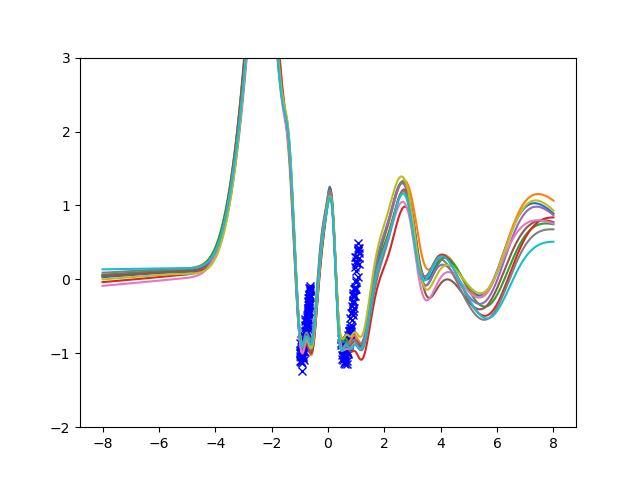

In [46]:
%matplotlib notebook

# Sample functions from posterior.
rs = npr.RandomState(0)
mean, log_std = mod.unpack_params(var_params)
#rs = npr.RandomState(0)
sample_weights = rs.randn(10, num_weights) * np.exp(log_std) + mean
plot_inputs = np.linspace(-8, 8, num=400)
outputs = predictions(sample_weights, np.expand_dims(plot_inputs, 1))

# Plot data and functions.
fig, ax = plt.subplots()
ax.plot(inputs.ravel(), targets.ravel(), 'bx')
ax.plot(plot_inputs, outputs[:, :, 0].T)
ax.set_ylim([-2, 3])
plt.draw()
plt.pause(1.0/60.0)